# Bayesian GMM and Embedded Selection of the Number of Components

**Table of contents**<a id='toc0_'></a>    
1. [Import Dependencies](#toc1_)    
2. [Create a Toy Dataset](#toc2_)    
3. [Find the best number of components using the elbow technique](#toc3_)    
4. [Detect anomalies](#toc4_)    
5. [Bayesian Clustering](#toc5_)    
6. [Notes](#toc6_)    
6.1. [AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion)?](#toc6_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

The goal of this notebook is to create a Bayesian GMM clustering algorithm that can adaptively find the best number of GMM components by using the elbow technique. The algorithm will also be robust against anomalous points by giving the user the option to either remove the anomalous points before clustering or to use the probabilistic Bayesian GMM to exclude the anomalous points.

To implement this, we will use the following steps:
1. Find the optimal number of components using the elbow technique and GMM clustering. GMM here is used instead of Bayesian GMM because the Bayesian GMM does not have a BIC method. BIC is used to find the optimal number of components.
2. Fit the Bayesian GMM model with the optimal number of components.
3. Detect anomalies by setting a confidence threshold. Anomalies are points with a low probability of belonging to any cluster.

## 1. <a id='toc1_'></a>[Import Dependencies](#toc0_)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler

## 2. <a id='toc2_'></a>[Create a Toy Dataset](#toc0_)

In [6]:
# Generate sample data
np.random.seed(0)
n_samples = 500
C = np.array([[0.0, -0.1], [1.7, 0.4]])
component_1 = np.dot(np.random.randn(n_samples, 2), C)
component_2 = 0.7 * np.random.randn(n_samples, 2) + np.array([-4, 1])
X = np.concatenate([component_1, component_2])

## 3. <a id='toc3_'></a>[Find the best number of components using the elbow technique](#toc0_)

In [4]:
# Elbow method to find optimal number of components
def plot_elbow(X, max_components=15):
    bic_scores = []
    n_components_range = range(1, max_components + 1)
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
    
    plt.figure(figsize=(8, 4))
    plt.plot(n_components_range, bic_scores, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC Score')
    plt.title('Elbow Method for Optimal Number of Components')
    plt.show()
    
    # Find the elbow point
    elbow_point = np.argmin(np.gradient(np.gradient(bic_scores))) + 1  # (+1): At least one component is chosen.
    return elbow_point


> ``TODO``: Scale the dataset before clustering and finding the elbow point. Then return a dataframe with the scaled data and the elbow point.

+ Deploy:

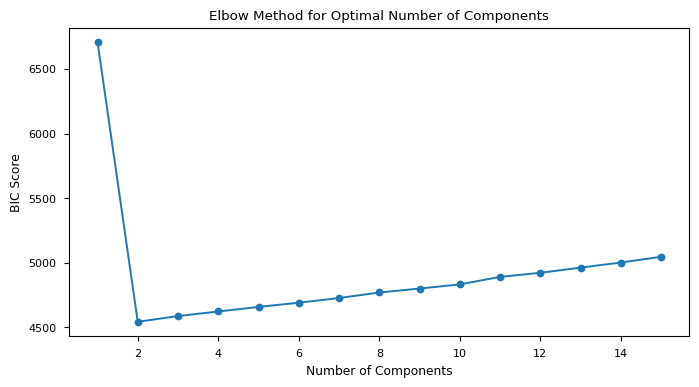

Optimal number of components: 11


In [5]:
optimal_components = plot_elbow(X)
print(f"Optimal number of components: {optimal_components}")

> ``TODO``: Annotation at elbow point for imporoved visualization. Add a legend.

## 4. <a id='toc4_'></a>[Detect anomalies](#toc0_)

In [7]:
# Anomaly detection
def detect_anomalies(X, gmm, confidence_limit=0.01):
    probs = gmm.predict_proba(X)
    max_probs = np.max(probs, axis=1)
    anomalies = max_probs < confidence_limit
    return anomalies

> ``TODO``: Implement another anomaly detection algorithms. The user can then choose the one that best fits the data.

## 5. <a id='toc5_'></a>[Bayesian Clustering](#toc0_)

In [8]:
# Plot clusters and anomalies
def plot_clusters(X, gmm, anomalies):
    labels = gmm.predict(X)
    probs = gmm.predict_proba(X)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=40, edgecolor='k', alpha=0.6)
    
    # Mark anomalies
    plt.scatter(X[anomalies, 0], X[anomalies, 1], c='red', marker='x', s=100, label='Anomalies')
    
    # Plot cluster centers
    centers = gmm.means_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75, marker='X')
    
    plt.title('Bayesian GMM Clustering with Anomalies')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

> ``TODO``: Plot the probabilistic decision boundaries of the Bayesian GMM.

/home/gfalouji/miniconda3/envs/ecpa/lib/python3.12/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


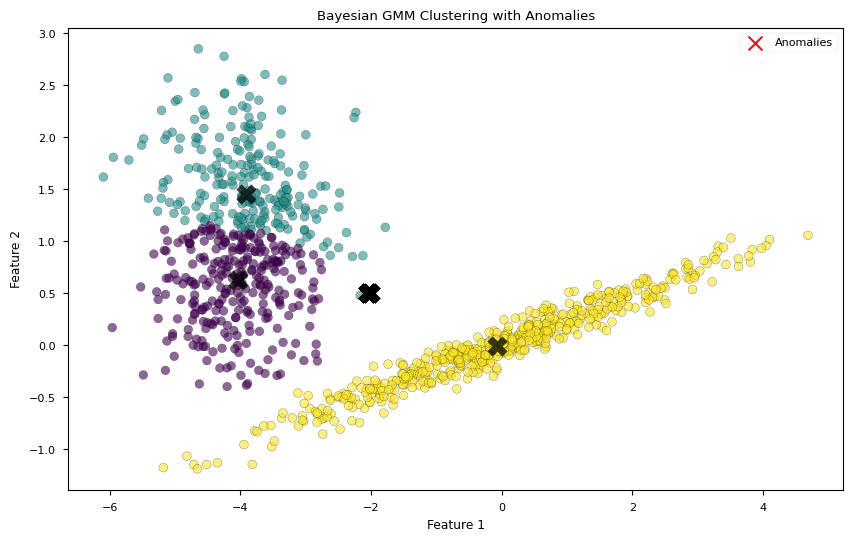

In [9]:
# Fit Bayesian GMM with optimal components
gmm = BayesianGaussianMixture(n_components=optimal_components, random_state=0)
gmm.fit(X)

# Detect anomalies
confidence_limit = 0.01
anomalies = detect_anomalies(X, gmm, confidence_limit)

# Plot clusters and anomalies
plot_clusters(X, gmm, anomalies)


> ``TODO``: Implement on another dataset to test the algorithm.

## 6. <a id='toc6_'></a>[Notes](#toc0_)

### 6.1. <a id='toc6_1_'></a>[AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion)?](#toc0_)

Both BIC and AIC are criteria for model selection among a finite set of models. They balance the goodness of fit of the model against its complexity (the number of parameters). The general idea is to penalize models with more parameters to prevent overfitting.

#### AIC (Akaike Information Criterion)

$$ \text{AIC} = 2k - 2\ln(L) $$
  - $k$ is the number of parameters in the model.
  - $L$ is the maximum value of the likelihood function for the model.

- **Usage:** AIC is used to compare models, with the model having the lowest AIC being preferred. It tends to be more lenient on the number of parameters compared to BIC, making it more suitable when you want **to avoid underfitting**.

- **When to Use:** AIC is generally preferred when:
  - You have a relatively **small sample size**.
  - The primary goal is to find a model that best predicts new data rather than explaining the data at hand.

#### BIC (Bayesian Information Criterion)

$$\text{BIC} = k \ln(n) - 2\ln(L)$$
  - $k$ is the number of parameters in the model.
  - $n$ is the number of data points.
  - $L$ is the maximum value of the likelihood function for the model.

- **Usage:** Like AIC, BIC is used to compare models, with the model having the lowest BIC being preferred. BIC imposes a larger penalty for models with more parameters, which generally leads to selecting simpler models.

- **When to Use:** BIC is preferred when:
  - You have a large sample size.
  - The primary goal is to find the true model (assuming one of the models is true).
  - You are more concerned with avoiding overfitting.

#### How to Use Both

 - Fit multiple candidate models to the data.
 - Calculate the AIC and BIC for each model.
 - Compare the AIC and BIC values across models.
   - Select the model with the lowest AIC and the model with the lowest BIC.
     - Lowest AIC is selected for predictive purposes
     - Lowest BIC is selected if model simplicity is a priority.


#### Practical Considerations
- **Consistency:** 
  - BIC is consistent, meaning that as the sample size increases, the probability of selecting the true model (if one of the models is true) approaches 1. 
  - AIC is not consistent in this sense but is often preferred for predictive accuracy.
- **Sample Size:** 
  - BIC generally prefers simpler models as the sample size grows.
  - AIC may still favor more complex models.
- **Objective:** 
  - AIC often being used for predictive accuracy and BIC for identifying the true model among the candidates.
